In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
#from torchvision.transforms import transforms

from lib.cfg import *
from lib.dataloader import get_calcification_data_index, DatasetThyroid
from lib.model import Unet

In [2]:
# Dataloader init
df_data_index = get_calcification_data_index()

idx_train, idx_test = train_test_split(
    list(range(len(df_data_index))),
    test_size=0.2, 
    random_state=0
)

print('Data train size: ', len(idx_train))
print('Data test size: ', len(idx_test))
df_data_index_train = df_data_index.iloc[idx_train]
df_data_index_test = df_data_index.iloc[idx_test]

batch_size_test = 1
dataloader_test = DataLoader(
    DatasetThyroid(df_data_index_test, image_transform, mask_transform, False), 
    batch_size=batch_size_test,
    shuffle=True,
    num_workers=2
)


Data train size:  694
Data test size:  174


In [3]:
# U-Net init
unet = Unet(3, 1).cuda()
unet.load_state_dict(torch.load('./unet_calcification_epoch30.pth'))

<All keys matched successfully>

# Visualization

In [16]:
batch = next(iter(dataloader_test))

img = batch[0]
mask_gt = batch[1]
pid = batch[3]

img = img.cuda()
mask_pred = unet(img)

i = 0
pid_str = str(int(pid[i].numpy()))
img_raw = plt.imread('./thyroid_data/CEUS1012_ex_sight/P_TT-' + pid_str + '.png')
mask_pred_proba = mask_pred[i].detach().cpu().numpy()[0]
mask_pred_threshold = mask_pred_proba > 0

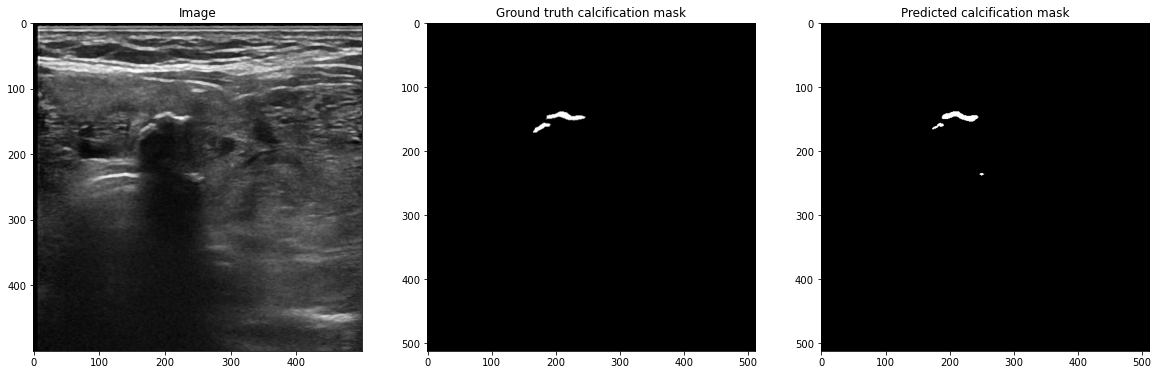

In [17]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(131)
ax.set_title('Image')
plt.imshow(img_raw)

ax = fig.add_subplot(132)
ax.set_title('Ground truth calcification mask')
plt.imshow(mask_gt[i].numpy()[0], cmap='gray')

# ax = fig.add_subplot(223)
# ax.set_title('Calcification probability')
# plt.imshow(mask_pred_proba)

ax = fig.add_subplot(133)
ax.set_title('Predicted calcification mask')
plt.imshow(mask_pred_threshold, cmap='gray')

plt.show()